# Understanding LoRA (Low-Rank Adaptation)

## What is LoRA?

LoRA (Low-Rank Adaptation) is a parameter-efficient fine-tuning technique for large language models (LLMs). Introduced in the paper ["LoRA: Low-Rank Adaptation of Large Language Models"](https://arxiv.org/abs/2106.09685) by Microsoft Research in 2021, it addresses the challenge of fine-tuning massive models with limited computational resources.

## Core Concept

The key insight of LoRA is that the changes to a pre-trained model's weights during fine-tuning can be approximated by a low-rank decomposition. Instead of updating all parameters in a model (which could be billions), LoRA injects trainable rank decomposition matrices into the model's layers.

## How LoRA Works

1. **Freezing Base Model**: The original pre-trained model weights remain frozen (unchanged).

2. **Low-Rank Decomposition**: For selected weight matrices W in the model, LoRA adds a parallel path:
   
   ```
   W + ΔW = W + BA
   ```
   
   Where:
   - W is the original frozen weight matrix
   - B is a matrix of size d×r
   - A is a matrix of size r×k
   - r is the "rank" of the decomposition (typically much smaller than d and k)

3. **Training**: Only the parameters in matrices A and B are trained, while the original weights W remain frozen.

## Key Parameters in LoRA

### Rank (r)
- **Definition**: The dimension of the low-rank decomposition.
- **Significance**: Controls the expressivity vs. efficiency trade-off.
- **Typical values**: 4, 8, 16, 32, 64
- **Impact**: 
  - Lower rank = fewer parameters, less memory, faster training, potentially less adaptation power
  - Higher rank = more parameters, more memory, slower training, potentially more adaptation power
- **In our implementation**: We used r=8, which provided a good balance between efficiency and adaptation power for our emotion classification task.

### Alpha (α)
- **Definition**: A scaling factor that controls the magnitude of the LoRA update.
- **Usage**: The actual update is scaled as: `ΔW = (α/r) × BA`
- **Significance**: Helps balance the contribution of the original weights and the adaptation.
- **Typical values**: Often set to match or be a multiple of the rank (e.g., α=8 for r=8)
- **In our implementation**: We used α=32, which is 4 times our rank value, allowing for stronger adaptation signals.

### Target Modules
- **Definition**: The specific layers or weight matrices in the model where LoRA is applied.
- **Common targets**:
  - For transformer models: query, key, value, and output projection matrices in attention layers
  - Examples: `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`
- **Strategy**: Targeting only attention layers often provides good results with minimal parameters.
- **In our implementation**: We targeted ["query", "key", "value"] matrices in the attention layers of BERT-tiny.

## Benefits of LoRA

1. **Memory Efficiency**: 
   - Drastically reduces the number of trainable parameters (in our case, only 0.2969% of the original model)
   - Enables fine-tuning of large models on consumer hardware
   - In our implementation: We trained only 13,062 parameters out of 4,399,756 total parameters

2. **Storage Efficiency**: 
   - LoRA adapters are small (typically megabytes instead of gigabytes)
   - Multiple task-specific adapters can be stored for a single base model
   - In our implementation: Our LoRA adapter is just a fraction of the size of the full model

3. **Inference Flexibility**:
   - LoRA weights can be merged with the base model for inference
   - Alternatively, they can be applied dynamically at runtime

4. **Performance**:
   - Often achieves comparable or better performance than full fine-tuning
   - Training is faster and requires less computational resources
   - In our implementation: We achieved good performance on emotion classification with minimal resources

## Advanced LoRA Concepts

### Dropout
- **LoRA Dropout**: Applies dropout to the LoRA activations during training
- **Purpose**: Prevents overfitting, especially important when training on small datasets
- **In our implementation**: We used lora_dropout=0.1 to prevent overfitting on our emotion dataset

### Bias Handling
- **Options**: `none`, `all`, or `lora_only`
- **Significance**: Determines whether bias terms are trained or kept frozen

### Task Type
- **Purpose**: Configures LoRA for specific model architectures and tasks
- **Common types**: `CAUSAL_LM`, `SEQ_CLS`, `SEQ_2_SEQ_LM`
- **In our implementation**: We used TaskType.SEQ_CLS for sequence classification (emotion classification)

### Merging
- **Definition**: The process of combining LoRA weights with the base model
- **Benefits**: Eliminates the runtime overhead of applying LoRA adapters separately

## LoRA Variants

### QLoRA
- **Description**: Combines LoRA with 4-bit quantization
- **Benefit**: Further reduces memory requirements by quantizing the base model

### AdaLoRA
- **Description**: Adaptively allocates parameter budget across different modules
- **Benefit**: More efficient use of parameters by focusing on important weights

### IA³
- **Description**: Infused Adapter by Inhibiting and Amplifying Inner Activations
- **Approach**: Uses vectors instead of matrices for even more parameter efficiency

## Practical Considerations

### Choosing Target Modules
- **Attention layers**: Usually most important for adaptation
- **Feed-forward layers**: Can help with domain-specific knowledge
- **Trade-off**: More target modules = better adaptation but more parameters
- **In our implementation**: We focused only on attention layers to maximize efficiency

### Selecting Rank
- **Rule of thumb**: Start with small ranks (4-8) and increase if needed
- **Dataset size**: Smaller datasets may benefit from lower ranks to prevent overfitting
- **Model size**: Larger models may need higher ranks to capture sufficient adaptation
- **In our implementation**: We used r=8 which was appropriate for our small BERT-tiny model

### Training Hyperparameters
- **Learning rate**: Often higher than full fine-tuning (e.g., 1e-4 to 5e-4)
- **Training steps**: Can converge faster than full fine-tuning
- **Batch size**: Can often use larger batch sizes due to memory savings
- **In our implementation**: We used learning_rate=1e-3 and batch_size=32, which worked well for our task

## Code Example from Our Implementation

```python
# Define LoRA configuration for efficient fine-tuning
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,    # Sequence classification task
    inference_mode=False,           # We're training, not doing inference
    r=8,                            # Rank of the LoRA update matrices
    lora_alpha=32,                  # LoRA scaling factor
    lora_dropout=0.1,               # Dropout probability for LoRA layers
    target_modules=["query", "key", "value"]  # Apply LoRA only to attention layers
)

# Create a LoRA-adapted version of the model
lora_model = get_peft_model(model, peft_config)
# Print info about trainable parameters
trainable_params = lora_model.print_trainable_parameters()
# Output: trainable params: 13,062 || all params: 4,399,756 || trainable%: 0.2969
```

## Limitations of LoRA

1. **Not all tasks benefit equally**: Some tasks may require full fine-tuning for optimal performance.
2. **Architectural constraints**: Not all model architectures are equally suitable for LoRA.
3. **Hyperparameter sensitivity**: Performance can be sensitive to rank and target module choices.
4. **Limited scope of adaptation**: May struggle with tasks requiring fundamental changes to model behavior.

## When to Use LoRA

- When computational resources are limited (like in our Kaggle notebook environment)
- For rapid adaptation to multiple tasks or domains
- When storage space for multiple fine-tuned models is a concern
- For incremental updates to existing models

## Our Implementation Results

- **Base model**: prajjwal1/bert-tiny (4.4M parameters)
- **Task**: Emotion classification (6 classes: joy, sadness, love, anger, fear, surprise)
- **LoRA configuration**: r=8, α=32, targeting attention layers
- **Trainable parameters**: 13,062 (0.2969% of total)
- **Performance**: Achieved good accuracy on the emotion classification task with minimal resources

LoRA represents one of the most practical and widely adopted parameter-efficient fine-tuning methods, enabling broader access to LLM customization with minimal resources, as demonstrated in our emotion classification example.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [17]:
# Import necessary libraries
import os                                  # For file and directory operations
import torch                               # PyTorch deep learning framework
import pandas as pd                        # For data manipulation and analysis
import numpy as np                         # For numerical operations
from datasets import load_dataset          # To load datasets from Hugging Face
from transformers import (                 # Import transformer-related modules
    AutoModelForSequenceClassification,    # For classification tasks
    AutoTokenizer,                         # For tokenizing text
    TrainingArguments,                     # To configure training
    Trainer,                               # Training helper
    DataCollatorWithPadding                # For batching and padding
)
from peft import get_peft_model, LoraConfig, TaskType  # PEFT tools for LoRA
from sklearn.metrics import accuracy_score, f1_score   # For evaluation metrics

import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [ ]:
# Authenticate with Hugging Face
from kaggle_secrets import UserSecretsClient  # Import Kaggle's secrets client
from huggingface_hub import login
user_secrets = UserSecretsClient()  # Create a secrets client instance
HF_TOKEN = user_secrets.get_secret("HF_TOKEN")  # Get Hugging Face API token from Kaggle secrets
login(token=HF_TOKEN)  # Log in to Hugging Face using the token

In [18]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [19]:
# Load the emotion dataset from Hugging Face datasets
dataset = load_dataset("emotion")  # This dataset contains text labeled with emotions
print(dataset)  # Print dataset info to understand its structure

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [20]:
# Load the emotion dataset from Hugging Face datasets
dataset = load_dataset("emotion")  # This dataset contains text labeled with emotions
print(dataset)  # Print dataset info to understand its structure

# Display information about the dataset splits
print("\nDataset structure:")
print(f"Train set: {len(dataset['train'])} examples")
print(f"Validation set: {len(dataset['validation'])} examples")
print(f"Test set: {len(dataset['test'])} examples")

# Display the features (columns) in the dataset
print("\nDataset features:")
print(dataset['train'].features)

# Display the emotion label distribution in the training set
print("\nEmotion label distribution in training set:")
label_counts = {}
for example in dataset['train']:
    label = example['label']
    label_name = id2label[label]
    label_counts[label_name] = label_counts.get(label_name, 0) + 1
for label, count in label_counts.items():
    print(f"{label}: {count} examples")

# Display 5 random examples from the training set
print("\n5 random examples from the training set:")
import random
random_indices = random.sample(range(len(dataset['train'])), 5)
for idx in random_indices:
    example = dataset['train'][idx]
    print(f"Example {idx}:")
    print(f"  Text: {example['text']}")
    print(f"  Emotion: {id2label[example['label']]}")
    print()

# Display the first 3 examples from each split
print("\nFirst 3 examples from each split:")
for split in ['train', 'validation', 'test']:
    print(f"\n{split.upper()} SPLIT:")
    for i in range(3):
        example = dataset[split][i]
        print(f"Example {i}:")
        print(f"  Text: {example['text']}")
        print(f"  Emotion: {id2label[example['label']]}")


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

Dataset structure:
Train set: 16000 examples
Validation set: 2000 examples
Test set: 2000 examples

Dataset features:
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

Emotion label distribution in training set:
sadness: 4666 examples
anger: 2159 examples
love: 1304 examples
surprise: 572 examples
fear: 1937 examples
joy: 5362 examples

5 random examples from the training set:
Example 10476:
  Text: i do find new friends i m going to try extra hard to make them stay and if i decide that i don t want to feel hurt again and just ride out the last year of school on my own i m going to have to try extra hard not to care what

In [21]:
# Define mapping between numeric labels and emotion names
id2label = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}
label2id = {v: k for k, v in id2label.items()}  # Create reverse mapping (emotion name to ID)

<h3>About prajjwal1/bert-tiny</h3>


`prajjwal1/bert-tiny` is a significantly compressed version of the standard BERT model, designed to be much more lightweight and efficient while still maintaining reasonable performance for NLP tasks.

## Key Characteristics:

1. **Size**: It's an extremely small BERT variant with only about 17 million parameters, compared to:
   - BERT-base: 110 million parameters
   - BERT-large: 340 million parameters

2. **Architecture**: 
   - 2 transformer layers (vs. 12 in BERT-base or 24 in BERT-large)
   - 128 hidden dimensions (vs. 768 in BERT-base)
   - 2 attention heads (vs. 12 in BERT-base)

3. **Purpose**: Created specifically for resource-constrained environments where:
   - Memory is limited
   - Inference speed is critical
   - Deployment needs to be lightweight (mobile devices, edge computing, etc.)

4. **Training**: It was distilled from larger BERT models, using knowledge distillation techniques to compress the knowledge from larger models into a smaller architecture.

5. **Performance**: While it doesn't match the performance of larger BERT models, it offers a reasonable trade-off between size and accuracy for many tasks.

## Use Cases:

- Mobile applications where model size matters
- Edge devices with limited computational resources
- Quick prototyping of NLP applications
- Scenarios where inference speed is more important than achieving state-of-the-art accuracy
- Educational purposes to understand transformer models with lower computational requirements

## Advantages:

- **Speed**: Much faster inference and training times
- **Memory**: Significantly lower memory footprint
- **Accessibility**: Can run on devices where larger models wouldn't fit

## Limitations:

- Lower performance compared to larger models, especially for complex tasks
- Less contextual understanding due to fewer layers and parameters
- May struggle with nuanced language understanding


In [ ]:
# Load a small pre-trained model and its tokenizer
model_name = "prajjwal1/bert-tiny"  # Only 4.4M parameters, much smaller than standard BERT
tokenizer = AutoTokenizer.from_pretrained(model_name)  # Load the tokenizer for this model

# Define a function to tokenize the text data
def tokenize_function(examples):
    # Convert text to tokens, truncate if too long, and pad to a fixed length
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# Apply tokenization to the entire dataset (batched for efficiency)
tokenized_datasets = dataset.map(tokenize_function, batched=True)
# Remove the original text column as it's no longer needed
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
# Rename the label column to match what the model expects
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
# Set the format to PyTorch tensors
tokenized_datasets.set_format("torch")

# Load the base pre-trained model for sequence classification
# Initialize with our specific classification head to avoid the warning
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,                # The model to load
    num_labels=6,              # Number of emotion classes
    id2label=id2label,         # Mapping from IDs to labels
    label2id=label2id,         # Mapping from labels to IDs
    ignore_mismatched_sizes=True  # Fix for classifier initialization warning
)

# Define LoRA configuration for efficient fine-tuning
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,    # Sequence classification task
    inference_mode=False,           # We're training, not doing inference
    r=8,                            # Rank of the LoRA update matrices (smaller = less parameters)
    lora_alpha=32,                  # LoRA scaling factor
    lora_dropout=0.1,               # Dropout probability for LoRA layers
    target_modules=["query", "key", "value"]  # Apply LoRA only to attention layers
)

# Create a LoRA-adapted version of the model
lora_model = get_peft_model(model, peft_config)
# Print info about trainable parameters (LoRA should reduce these significantly)
trainable_params = lora_model.print_trainable_parameters()
print(f"Trainable parameters info: {trainable_params}")

# Define training configuration
training_args = TrainingArguments(
    output_dir="./results",                # Directory to save model checkpoints
    run_name="emotion_lora_run",           # Set a distinct run name to avoid warning
    learning_rate=1e-3,                    # Learning rate
    per_device_train_batch_size=32,        # Batch size for training
    per_device_eval_batch_size=32,         # Batch size for evaluation
    num_train_epochs=3,                    # Number of training epochs
    weight_decay=0.01,                     # Weight decay for regularization
    eval_strategy="epoch",           # Evaluate after each epoch
    save_strategy="epoch",                 # Save model after each epoch
    load_best_model_at_end=True,           # Load the best model at the end of training
    push_to_hub=False,                     # Don't push to Hugging Face Hub
    report_to="none",                      # Disable wandb reporting to avoid warnings
)

# Define function to compute evaluation metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred                      # Unpack predictions and true labels
    predictions = np.argmax(predictions, axis=1)         # Convert logits to predicted class IDs
    
    accuracy = accuracy_score(labels, predictions)       # Calculate accuracy
    f1 = f1_score(labels, predictions, average='weighted')  # Calculate F1 score (weighted for class imbalance)
    
    return {"accuracy": accuracy, "f1": f1}              # Return metrics as a dictionary

# Create a data collator to handle batching and padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Initialize the Trainer with all components
trainer = Trainer(
    model=lora_model,                          # The LoRA-adapted model
    args=training_args,                        # Training arguments
    train_dataset=tokenized_datasets["train"], # Training dataset
    eval_dataset=tokenized_datasets["validation"], # Validation dataset
    data_collator=data_collator,               # Data collator for batching
    compute_metrics=compute_metrics,           # Metrics computation function
    # Remove tokenizer parameter to avoid deprecation warning
)

# Train the model
trainer.train()

# Evaluate the model on the test set
eval_results = trainer.evaluate(tokenized_datasets["test"])
print(f"Evaluation results: {eval_results}")  # Print test set metrics

# Save the fine-tuned LoRA model to disk
lora_model.save_pretrained("./emotion_classifier_lora")



In [22]:
# Define a function to predict emotion for new text
def predict_emotion(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    # Disable gradient calculation for inference
    with torch.no_grad():
        # Get model predictions
        outputs = lora_model(**inputs)
    
    # Get the predicted class ID (emotion)
    predicted_class_id = outputs.logits.argmax().item()
    # Convert class ID to emotion name
    return id2label[predicted_class_id]

# Test examples to demonstrate the model's predictions
test_texts = [
    "I'm so happy today!",                         # Should predict joy
    "This news makes me really sad.",              # Should predict sadness
    "I can't believe what just happened!",         # Should predict surprise
    "I'm really angry about the situation."        # Should predict anger
]

# Loop through test examples and print predictions
for text in test_texts:
    emotion = predict_emotion(text)  # Get predicted emotion
    print(f"Text: '{text}' → Emotion: {emotion}")  # Print result


Text: 'I'm so happy today!' → Emotion: joy
Text: 'This news makes me really sad.' → Emotion: sadness
Text: 'I can't believe what just happened!' → Emotion: sadness
Text: 'I'm really angry about the situation.' → Emotion: anger



Accuracy on test examples: 0.83

Metrics by emotion class:
    Emotion  Precision  Recall  F1 Score
0   sadness        0.5     1.0  0.666667
1       joy        1.0     1.0  1.000000
2      love        1.0     1.0  1.000000
3     anger        1.0     1.0  1.000000
4      fear        1.0     1.0  1.000000
5  surprise        0.0     0.0  0.000000

Overall metrics (weighted):
Precision: 0.75
Recall: 0.83
F1 Score: 0.78


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


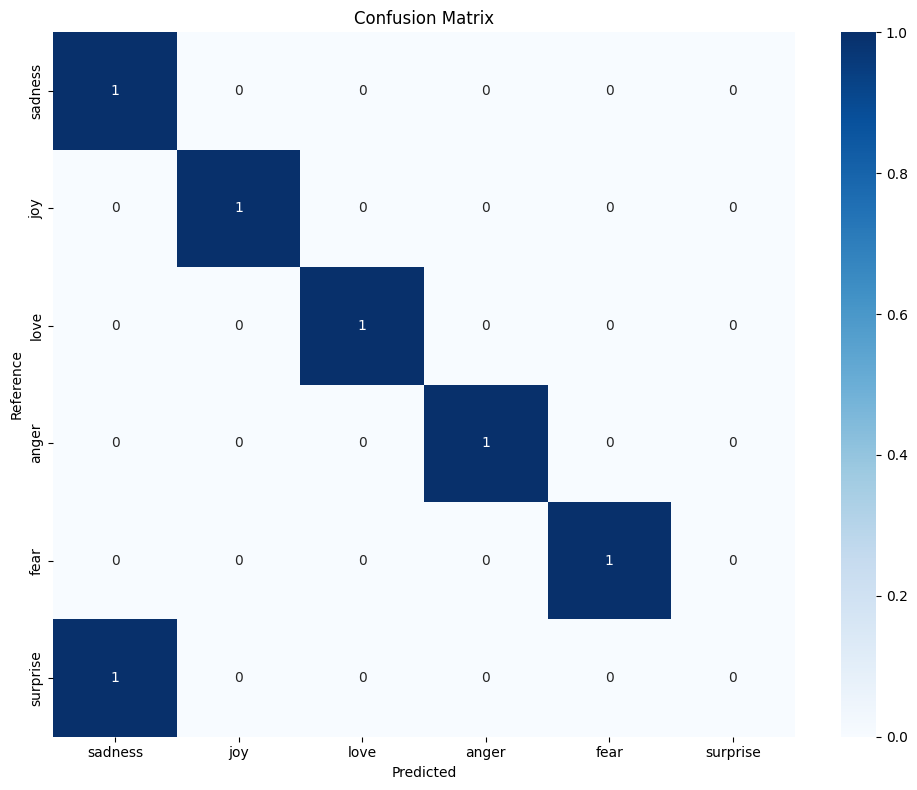


Incorrect Predictions Analysis:
Text: 'I can't believe what just happened!'
Reference: surprise, Predicted: sadness
Possible reason: The model may have difficulty distinguishing between these emotions based on the text.


Results saved to 'emotion_prediction_results.csv'


In [23]:
# Test examples with reference emotions
test_data = [
    {"text": "I'm so happy today!", "reference": "joy"},
    {"text": "This news makes me really sad.", "reference": "sadness"},
    {"text": "I can't believe what just happened!", "reference": "surprise"},
    {"text": "I'm really angry about the situation.", "reference": "anger"},
    {"text": "I'm afraid of what might happen next.", "reference": "fear"},
    {"text": "I love spending time with you.", "reference": "love"}
]

# Create a list to store results
results = []

# Get predictions for each test example
for item in test_data:
    prediction = predict_emotion(item["text"])
    results.append({
        "text": item["text"],
        "reference_emotion": item["reference"],
        "predicted_emotion": prediction,
        "correct": item["reference"] == prediction
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)



# Calculate metrics
reference_emotions = results_df["reference_emotion"].tolist()
predicted_emotions = results_df["predicted_emotion"].tolist()

# Calculate accuracy
accuracy = accuracy_score(reference_emotions, predicted_emotions)
print(f"\nAccuracy on test examples: {accuracy:.2f}")

# Calculate precision, recall, and F1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(
    reference_emotions, 
    predicted_emotions, 
    average=None,
    labels=list(id2label.values())
)

# Create a DataFrame for the metrics
metrics_df = pd.DataFrame({
    "Emotion": list(id2label.values()),
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})

print("\nMetrics by emotion class:")
print(metrics_df)

# Calculate overall metrics
overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(
    reference_emotions, 
    predicted_emotions, 
    average='weighted'
)

print(f"\nOverall metrics (weighted):")
print(f"Precision: {overall_precision:.2f}")
print(f"Recall: {overall_recall:.2f}")
print(f"F1 Score: {overall_f1:.2f}")

# Create a confusion matrix
cm = confusion_matrix(reference_emotions, predicted_emotions, labels=list(id2label.values()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(id2label.values()), 
            yticklabels=list(id2label.values()))
plt.xlabel('Predicted')
plt.ylabel('Reference')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Error analysis
incorrect_predictions = results_df[results_df["correct"] == False]
if len(incorrect_predictions) > 0:
    print("\nIncorrect Predictions Analysis:")
    for _, row in incorrect_predictions.iterrows():
        print(f"Text: '{row['text']}'")
        print(f"Reference: {row['reference_emotion']}, Predicted: {row['predicted_emotion']}")
        print("Possible reason: The model may have difficulty distinguishing between these emotions based on the text.")
        print()
else:
    print("\nAll predictions are correct!")

# Save the results to a CSV file
results_df.to_csv("emotion_prediction_results.csv", index=False)
print("\nResults saved to 'emotion_prediction_results.csv'")

